# Chapter 20 - Approximate Bayesian Computation

ABC is a method of last resort when the other methods don't work - it often requires more computation than the other methods.

## The Kidney Tumour Problem

The problem came from Reddit, and has to do with a tumour - is it more likely than not that the tumour formed while the patient was in the military? If so he would get different benefits.

Growth rate of the tumour is measured in two ways:
- Volumetric doubling time - how long it would take for the tumour to double in volume
- Reciprocal doubling time (RDT) - the number of doublings per year

## A Simple Growth Model

We'll start with a simple model of tumour growth based on two assumptions:
1. Tumours grow with a constant doubling time
1. They are roughly spherical in shape

Let's define two points in time:
- `t1` is when the correspondent retired
- `t2` is when the tumour was detected

The time between `t1` and `t2` was about 9.0 years. As an example, let's assume that the diameter of the tumour was 1cm at `t1`, and estimate its size at `t2`.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calc_volume(diameter):
    factor = 4 * np.pi / 3
    return factor * (diameter / 2) ** 3

d1 = 1
v1 = calc_volume(d1)
v1

0.5235987755982988

In [6]:
# The median reported doubling time was 811 days, which corresponds to an RDT of 0.45 doublings / year
median_doubling_time = 811
rdt = 365 / median_doubling_time
rdt

0.45006165228113443

In [7]:
# The number of doublings that would have occurred between t1 and t2
interval = 9.0
doublings = interval * rdt
doublings

4.05055487053021

In [8]:
# this allows us to compute the volume at t2:
v2 = v1 * 2 ** doublings
v2

8.676351488087187

In [9]:
# We can go back from there to the diameter:
def calc_diameter(volume):
    return 2 * (3 / (4 * np.pi) * volume) ** (1/3)

d2 = calc_diameter(v2)
d2

2.5494480788327483

So if the tumour started out with a diameter of 1cm, then 9 years later it would be about 2.5cm.

## A More General Model

Given the size of a tumour at the time of diagnosis, we would like to know the distribution of its age. To find it, we'll run simulations of tumour growth to get the distribution of size conditioned on age. Then we'll compute the distribution of age conditioned on size.

The simulation starts with a small tumour and runs these steps:
1. Choose a value from the distribution of growth rates
1. Compute the size of the tumour at the end of the interval
1. Repeat until the tumour exceeds the maximum relevant size

Using the figures in the Zhange et. al. paper we can create an array of the estimated values of the RDT for the patients in the study.

In [10]:
# This is directly copied from the soln notebook - what is going on here?
from empiricaldist import Pmf
from utils import kde_from_sample

counts = [2, 29, 11, 6, 3, 1, 1]
rdts = np.arange(-1, 6) + 0.01
pmf_rdt = Pmf(counts, rdts)
pmf_rdt.normalize()

rdts = [5.089,  3.572,  3.242,  2.642,  1.982,  1.847,  1.908,  1.798,
        1.798,  1.761,  2.703, -0.416,  0.024,  0.869,  0.746,  0.257,
        0.269,  0.086,  0.086,  1.321,  1.052,  1.076,  0.758,  0.587,
        0.367,  0.416,  0.073,  0.538,  0.281,  0.122, -0.869, -1.431,
        0.012,  0.037, -0.135,  0.122,  0.208,  0.245,  0.404,  0.648,
        0.673,  0.673,  0.563,  0.391,  0.049,  0.538,  0.514,  0.404,
        0.404,  0.33,  -0.061,  0.538,  0.306]

rdt_sample = np.array(rdts)
len(rdt_sample)

53

<AxesSubplot:>

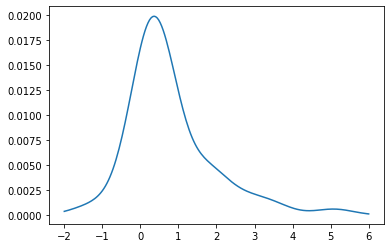

In [11]:
qs = np.linspace(-2, 6, num=201)
pmf_rdt = kde_from_sample(rdt_sample, qs)
pmf_rdt.plot()

## Simulation

Now we're ready to run the simulations. Starting with a small tumour, we'll simulate a series of intervals until the tumour reaches a maximum size.

At the beginning of each simulated interval, we'll choose a value from the distribution and compute the size of the tumour at the end.

I chose an interval of 245 days (about 8 months) because that was the median time between measurements in the data.

For the initial diameter, I chose 0.3cm because carcinomas smaller than that are less likely to be invasive and less likely to have the blood sypply needed for rapid growth. For the maximum diameter I chose 20cm.

In [12]:
interval = 245 / 365
min_diameter = 0.3
max_diameter = 20

v0 = calc_volume(min_diameter)
vmax = calc_volume(max_diameter)
v0, vmax

(0.014137166941154066, 4188.790204786391)

In [13]:
def simulate_growth(pmf_rdt):
    """ Simulates the growth of one tumour """
    age = 0
    volume = v0
    res = []
    
    while True:
        res.append((age, volume))
        if volume > vmax:
            break
        
        rdt = pmf_rdt.choice()
        age += interval
        doublings = rdt * interval
        volume *= 2 ** doublings
    
    columns = ['age', 'volume']
    sim = pd.DataFrame(res, columns=columns)
    sim['diameter'] = calc_diameter(sim['volume'])
    return sim

sim = simulate_growth(pmf_rdt)
sim.head()

,age,volume,diameter
0,0.000000,0.014137,0.300000
1,0.671233,0.023805,0.356909
2,1.342466,0.019398,0.333366
3,2.013699,0.018690,0.329256
4,2.684932,0.018690,0.329256


In [14]:
sim.tail()

,age,volume,diameter
31,20.808219,1652.182562,14.667400
32,21.479452,2997.066700,17.888171
33,22.150685,3228.688934,18.337601
34,22.821918,2104.407658,15.899266
35,23.493151,5436.692660,21.816181


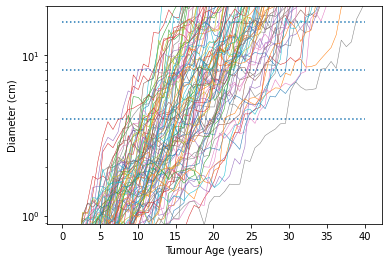

In [15]:
# To show the results graphically, let's run this a bunch of times and see what happens:
sims = [simulate_growth(pmf_rdt) for _ in range(101)]

# Now let's plot it!
fig, ax = plt.subplots()
ax.set_xlabel("Tumour Age (years)")
ax.set_ylabel("Diameter (cm)")
ax.set_yscale('log')
ax.set_ylim(top=20)
ax.hlines(y=4, xmin=0, xmax=40, linestyle='dotted')
ax.hlines(y=8, xmin=0, xmax=40, linestyle='dotted')
ax.hlines(y=16, xmin=0, xmax=40, linestyle='dotted')
for sim in sims:
    ax.plot(sim['age'], sim['diameter'], linewidth=0.5)

To compute the distribution more precisely, we can interpolate the growth curve to see when each one passes through a given size.

In [16]:
from empiricaldist import Cdf
from scipy.interpolate import interp1d

def interpolate_ages(sim, diameter):
    ages = []
    for sim in sims:
        interp = interp1d(sim['diameter'], sim['age'])
        age = interp(diameter)
        ages.append(float(age))
    return ages

ages = interpolate_ages(sims, 15)
cdf = Cdf.from_seq(ages)
print(cdf.median(), cdf.credible_interval(0.9))

22.34978139908607 [15.29029497 31.3646146 ]


So for a tumour 15 cm in diameter, the median age is about 22 years and the 90% credible interval is between 13 and 34 years. The probability that it formed less than 9 years ago is less than 1%:

In [17]:
1 - cdf(9)

1.0

However, this result is based on two modelling assumptions that could be problematic:
1. In the simulation, growth rate during each interval is independent of the previous one. However, it seems likely that in the real world there would be some sort of serial correlation - tumours that grew quickly in one interval would probably continue to grow quickly in the next interval
1. We assumed that the tumours are approximately spherical

The author ran some different sumulations that addressed these, and still found it unlikely that a tumour this large was less than 9 years old.

## Approximate Bayesian Computation

Big question: why was that relevant? There was nothing Bayesian about what we did - we just ran a bunch of simulations. Implicitly, we created a joint distribution of tumour size against age. By selecting a column we get a distribution of size conditioned on age, and by selecting a column we get a distribution of age conditioned on size.

The example is a first step toward Approximate Bayesian Computation.

## Counting Cells

This example comes from a blog post by Cameron Davidson-Pilon about the process that biologists use to estimate the concentration of cells in a sample of liquid. The example he presents is counting cells in a yeast slurry, which is a mixture of yeast and water used in brewing beer.

There are two steps to the process:
1. First, the slurry is diluted until the concentration is low enough that it is practical to count cells
1. Then a small sample is put on a hemocytometer, which is a specialized microscope slide that holds a fixed amount of liquid on a rectangular grid

The cells and the grid are visible in a microscope, making it possible to count the cells acurately.

As an example, say that we start with a yeast slurry with an unknown concentration of cells. Starting with a 1ml sample, we dilute it by adding it to a shaker w/ 9ml of water (concentration -> 1/10 of what it was). Then we dilute it again, and then a third time. By the end, we have diluted it by a factor of $10 ^ 3 = 1000$ times.

Then we add the diluted sample to the hemocytometer, which has a capacity of 0.0001ml spread over a 5 x 5 grid. Although the grid has 25 squares, it is standard practice to inspect only some of them (say, 5) and return the total number of cells in the inspected squares.

The process is simple enough, but at each step there are sources of error:

1. During the dilution process, liquids are measured using pipettes that introduce measurement error
1. The amount of liquid in the hemocytometer might vary from the specification
1. During each step of the sampling process, we might select more or less than the average number of cells, due to random variation

Davidson-Pilon presents a PyMC model that describes these errors. We'll start by replicating his model, then we'll adapy it for ABC.

Suppose that there are 25 squares in a grid. We count 5 of them and find a total of 49 cells.

In [18]:
total_squares = 25
squares_counted = 5
yeast_counted = 49

import pymc3 as pm
billion = 1e9

with pm.Model() as model:
    yeast_conc = pm.Normal('yeast conc', mu=2*billion, sd=0.4*billion)
    # this is the volume of the first shaker - supposed to be 9ml, but could be different!
    shaker1_vol = pm.Normal("shaker1 vol", mu=9.0, sd=0.05)
    shaker2_vol = pm.Normal("shaker2 vol", mu=9.0, sd=0.05)
    shaker3_vol = pm.Normal("shaker3 vol", mu=9.0, sd=0.05)
    
    # The initial sample from the slurry is supposed to be 1ml, but could be more or less. Same with all of the samples carried from each beaker to the next!
    yeast_slurry_vol = pm.Normal("yeast slurry volume", mu=1, sd=0.01)
    shaker1_to_shaker2_vol = pm.Normal("shaker1 to shaker2", mu=1.0, sd=0.01)
    shaker2_to_shaker3_vol = pm.Normal("shaker2 to shaker3", mu=1.0, sd=0.01)
    
    # Given the actual volumes in the samples and in the shakers, we can compute the effective dilution, which should be 1000 but might be higher or lower:
    dilution_shaker1 = yeast_slurry_vol / (yeast_slurry_vol + shaker1_vol)
    dilution_shaker2 = shaker1_to_shaker2_vol / (shaker1_to_shaker2_vol + shaker2_vol)
    dilution_shaker3 = shaker2_to_shaker3_vol / (shaker2_to_shaker3_vol + shaker3_vol)
    
    final_dilution = dilution_shaker1 * dilution_shaker2 * dilution_shaker3
    
    # The next step is to put it in the hemocytometer. The capacity should be 0.0001ml, but could be different
    # Here we use the Gamma distribution to model it so that we don't get negative values
    chamber_vol = pm.Gamma("chamber vol", mu=0.0001, sd=0.0001 / 20)
    
    # On average, the number of cells in the chamber is the product of the actual concentration, final dilution, and chamber volume
    # However, the actual number might vary; we'll use a Poisson distribution to model this
    yeast_in_chamber = pm.Poisson("yeast in chamber", mu=yeast_conc * final_dilution * chamber_vol)
    
    # Finally, each cell in the chamber will be in one of the squares we count with probability p = squares_counted / total_squares.
    # So the actual count follows a binomial distribution
    count = pm.Binomial("count", n=yeast_in_chamber, p=squares_counted/total_squares, observed=yeast_counted)
    

In [19]:
options = dict(return_inferencedata=False)

with model:
    trace = pm.sample(1000, **options)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [chamber vol, shaker2 to shaker3, shaker1 to shaker2, yeast slurry volume, shaker3 vol, shaker2 vol, shaker1 vol, yeast conc]
>Metropolis: [yeast in chamber]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [20]:
# Now we can use the sample to estimate the posterior distribution of yeast_conc and compute summary statistics
posterior_sample = trace['yeast conc'] / billion
cdf_pymc = Cdf.from_seq(posterior_sample)
cdf_pymc.mean(), cdf_pymc.credible_interval(0.9)

(2.261375694283407, array([1.84300637, 2.69452748]))

So the concentration is probably around 2.3 billion cells / mL, with a 90% credible interval from 1.8 - 2.7.

So far we've just been doing regular MCMC stuff. For this problem, it works! But now let's try it with ABC.

## Cell Counting with ABC

The fundamental idea of ABC is that we use the prior distribution to generate a sample of the parameters, and then simulate the sustem for each set of parameters in the sample.

In this case, since we already have the PyMC model, we can use `sample_prior_predictive` to do the sampling and simulation.

In [25]:
with model:
    prior_sample = pm.sample_prior_predictive(10000)

In [26]:
# The result is a dictionary containing samples from the prior distribution of the parameters, and the prior predictive distribution of count:
count = prior_sample['count']
count.mean()

39.989

In [27]:
# Now, to generate a sample from the posterior distribution, we'll select one the elements in the prior sample where the output
# of the simulation, `count`, matches the observed data, 49
mask = count == 49
mask.sum()

286

We can use `mask` to select the values of `yeast_conc` for the simulations that yield the observed data

In [32]:
posterior_sample2 = prior_sample['yeast conc'][mask] / billion

# Now estimate the CDF
cdf_abc = Cdf.from_seq(posterior_sample2)
cdf_abc.mean(), cdf_abc.credible_interval(0.9)

(2.2502721224343096, array([1.83992566, 2.69189445]))

(If you plot this against the MCMC results, you see that they are almost identical - the ABC ones are just noisier because the sample is smaller).

## When Do We Get To The Approximate Part?

The examples so are are similar to ABC, but neither of them demonstrates all of the elements of ABC. More generally, ABC is characterized by:
1. A prior distribution of parameters
1. A simulation of the system that generates the data
1. A criterion for when we should accept that the output of the simulation matches the data.

The kidney tumour example was missing the prior distribution, which was kind of OK because we could just simulate a lot of data.

The yeast example was more typical, but slightly off because we only accepted ones when the output matched our observed values exactly.

The result is approximate in the sense that we have a sample from the posterior distribution rather than the posterior distribution itself. But it is not approximate in the sense of ABC, which typically accepts simulations where the output matches the data only approximately.

To show how that works, let's extend the yeast example with an approximate matchin criterion.

In the previous section, we acepted a simulation if the output is exactly 49 and rejected it otherwise. As a result, we got only a few hundred samples out of the 10 000 that we simulated, which is not great.

We can make better use of the simulation if we give 'partial credit' when the output is close to 49. But how close? And how much credit?

One way to answer that is to back up to the second-last step of the simulation, where we know the number of cells in the chamber, and we use the binomial distribution to generate the final count.

If there are $n$ cells in the chamber, each has a probability $p$ of being counted, depending on whether it falls in one of the squares in the grid that get counted.

We can extract $n$ from the prior sample, like this:

In [33]:
n = prior_sample['yeast in chamber']
n.shape

(10000,)

In [34]:
p = squares_counted / total_squares
p

0.2

In [36]:
# use the binomial distribution to compute the likelihood of the data, yeast_counted, for each value of n and fixed value of p:
from scipy.stats import binom

likelihood = binom(n, p).pmf(yeast_counted).flatten()

When the expected count, `n * p`, is close to the actual count, `likelihood` is relatively high; when it is further away, likelihood is lower.

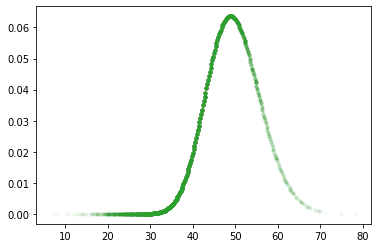

In [37]:
plt.plot(n * p, likelihood, '.', alpha=0.03, color="C2")

We can't use these likelihoods to do a Bayesian update, because they are incomplete: each likelihood is the probability of the data given `n`, which is the result of a single simulation.

However, we can use them to *weight* the results of the simulations. Instead of requiring the output of the simulation to match the data exactly, we'll use the likelihood to give partial credit when the result is close.

Here's how: we'll contstruct a Pmf that contains yeast concentractions as quantiles and the likelihoods as unnormalized probabilities:

In [38]:
qs = prior_sample['yeast conc'] / billion
ps = likelihood
posterior_pmf = Pmf(ps, qs)

# In the Pmf, values of yeast_conc that yield outputs close to the data map to higher probabilities.
# If we sort the quantities and normalize the probabilities, the result is an estimate of the posterior distribution
posterior_pmf.sort_index(inplace=True)
posterior_pmf.normalize()

posterior_pmf.mean(), posterior_pmf.credible_interval(0.9)

(2.2735253481424134, array([1.85924371, 2.69879243]))

The results are very similar to the values we got from MCMC.

## Exercises
### Exercise 20-1
The exercise is based on a blog post by Blaath, which is motivated by a tweet from Karl Broman, who wrote:

> That the first 11 socks in the laundry are distrinct suggests that there are a lot of socks.

Suppose that you pull 11 socks out of the laundry, and find that no two of them make a pair. Estimate the number of socks in the laundry.

To solve this problem, we'll use a model which Blaath suggests, which is based on these assumptions:
1. The laundry contains some number of pairs of socks, `n_pairs`, plus some number of odd (unpaired) socks, `n_odds`.
1. The pairs of socks are different from each other and different from the unpaired socks; in other words, the number of socks of each type is either 1 or 2, never more.

We'll use the prior distribution that Blaath suggests, which is:
- The number of socks follows a negative binomial distribution with a mean of 30 and standard deviation 15.
- The proportion of socks which are paired follows a beta distribution with parameters `alpha=15` and `beta=2`.

### Solution 20-1

In [39]:
from scipy.stats import nbinom, beta

mu = 30
p = 0.86666666
r = mu * (1 - p) / p

prior_n_socks = nbinom(r, 1-p)
prior_n_socks.mean(), prior_n_socks.std()

(30.0, 14.999999625000015)

In [40]:
prior_prop_pairs = beta(15,2)
prior_prop_pairs.mean()

0.8823529411764706

<AxesSubplot:>

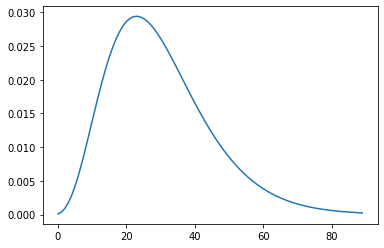

In [42]:
qs = np.arange(90)
ps = prior_n_socks.pmf(qs)
pmf = Pmf(ps, qs)
pmf.normalize()
pmf.plot()

<AxesSubplot:>

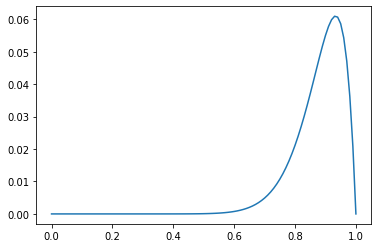

In [44]:
from utils import pmf_from_dist

qs = np.linspace(0, 1, 101)
pmf = pmf_from_dist(prior_prop_pairs, qs)
pmf.plot()

In [49]:
# Sample from the distribution
n_socks = prior_n_socks.rvs()
prop_pairs = prior_prop_pairs.rvs()

n_socks, prop_pairs

(24, 0.9009161021058195)

In [50]:
# Now we can calculate the number of paired and unpaired socks
n_pairs = np.round(n_socks // 2 * prop_pairs)
n_odds = n_socks - n_pairs * 2

n_pairs, n_odds

(11.0, 2.0)